In [38]:
import sys 
sys.path.append('/host/d/Github/')
import os
import torch
import numpy as np
import nibabel as nb
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

import CT_registration_diffusion.functions_collection as ff
import CT_registration_diffusion.Build_lists.Build_list as Build_list
import CT_registration_diffusion.Data_processing as Data_processing


In [30]:
# change the excel path to your own path
patient_list_spreadsheet = os.path.join('/host/d/Data/4DCT/Patient_lists/ct_list.xlsx')
build_sheet =  Build_list.Build(patient_list_spreadsheet)

batch_list, dataset_id_list, case_id_list, image_folder_list = build_sheet.__build__(batch_list = [0])

print('length of dataset_id_list:', len(dataset_id_list))
print('example of dataset_id_list:', dataset_id_list[1], ' corresponding case_id:', case_id_list[1], ' image_folder:', image_folder_list[1])

length of dataset_id_list: 16
example of dataset_id_list: DIR_LAB  corresponding case_id: Case2  image_folder: /host/d/Data/4DCT/DIR_LAB/Case2/resampled_image


In [57]:
# generator

# define augmentation functions here if needed
# random function
def random_rotate(i, z_rotate_degree = None, z_rotate_range = [-10,10], fill_val = None, order = 1):
    # only do rotate according to z (in-plane rotation)
    if z_rotate_degree is None:
        z_rotate_degree = random.uniform(z_rotate_range[0], z_rotate_range[1])

    if fill_val is None:
        fill_val = np.min(i)
    
    if z_rotate_degree == 0:
        return i, z_rotate_degree
    else:
        if len(i.shape) == 2:
            return Data_processing.rotate_image(np.copy(i), z_rotate_degree, order = order, fill_val = fill_val, ), z_rotate_degree
        else:
            return Data_processing.rotate_image(np.copy(i), [0,0,z_rotate_degree], order = order, fill_val = fill_val, ), z_rotate_degree

def random_translate(i, x_translate = None,  y_translate = None, translate_range = [-10,10]):
    # only do translate according to x and y
    if x_translate is None or y_translate is None:
        x_translate = int(random.uniform(translate_range[0], translate_range[1]))
        y_translate = int(random.uniform(translate_range[0], translate_range[1]))
    
    if len(i.shape) == 2:
        return Data_processing.translate_image(np.copy(i), [x_translate,y_translate]), x_translate,y_translate
    else:
        return Data_processing.translate_image(np.copy(i), [x_translate,y_translate,0]), x_translate,y_translate



class Dataset_4DCT(Dataset):
    def __init__(
        self,
        image_folder_list,
        image_size = [256,256,128], # target image size after center-crop

        cutoff_range = [-200,250], # default cutoff range for CT images
        shuffle = False,

        augment = True, # whether to do data augmentation
        augment_frequency = 0.3, # frequency of augmentation
      
    ):
        super().__init__()
        self.image_folder_list = image_folder_list
        self.image_size = image_size
       
        self.background_cutoff = cutoff_range[0]
        self.maximum_cutoff = cutoff_range[1]

        self.shuffle = shuffle
        self.augment = augment
        self.augment_frequency = augment_frequency

        self.num_files = len(image_folder_list)

        self.index_array = self.generate_index_array()
        # self.current_moving_file = None
        # self.current_moving_data = None
        # self.current_fixed_file = None
        # self.current_fixed_data = None
       

    def generate_index_array(self): 
        np.random.seed()
        index_array = []
        
        if self.shuffle == True:
            f_list = np.random.permutation(self.num_files)
        else:
            f_list = np.arange(self.num_files)

        index_array = [[f] for f in f_list]
        return index_array

    def __len__(self):
       return self.num_files
    
    def load_data(self, file_path):
        image = nb.load(file_path).get_fdata()
        return image

    def center_shift_crop(self,center, x_shift_range = [-10,10], y_shift_range = [-10,10], z_shift_range = [-5,5]):
        shift_x = np.random.randint(x_shift_range[0], x_shift_range[1]+1)
        shift_y = np.random.randint(y_shift_range[0], y_shift_range[1]+1)
        shift_z = np.random.randint(z_shift_range[0], z_shift_range[1]+1)
        if len(center) ==2: # 2D case
            center[0], center[1] = center[0] + shift_x, center[1] + shift_y
            return center
        elif len(center) ==3: # 3D case
            center[0], center[1], center[2] = center[0] + shift_x, center[1] + shift_y, center[2] + shift_z
        return center
        
    def __getitem__(self, index):
        file_num = self.index_array[index]
        current_image_folder = self.image_folder_list[file_num][0]
        
        # randomly pick two time frames
        timeframes = ff.find_all_target_files(['img*'], current_image_folder)
        t1, t2 = np.random.choice(len(timeframes), size=2, replace=False)
        moving_file = timeframes[t1]
        fixed_file = timeframes[t2]
        print('in this folder, I pick moving file:', moving_file, ' fixed file:', fixed_file)

        # load image
        moving_image = self.load_data(moving_file)
        fixed_image = self.load_data(fixed_file)

        # now let's center-crop to image size = self.image_size
        print('before center-crop, image shape:', moving_image.shape)
        # find the center
        image_shape = moving_image.shape
        center = [int(image_shape[0]/2), int(image_shape[1]/2), int(image_shape[2]/2)]
        # randomly shift the center a bit for data augmentation
        if self.augment and (np.random.rand() < self.augment_frequency):
            center = self.center_shift_crop(center)

        # crop
        # moving_image = Data_process.center_crop_image(moving_image, center, self.image_size)
        # fixed_image = Data_process.center_crop_image(fixed_image, center, self.image_size)
        # print('after center-crop, image shape:', moving_image.shape)

        # preprocess if needed
        # cutoff 
        print('before cutoff, image range:', np.min(moving_image), np.max(moving_image))
        if self.background_cutoff is not None and self.maximum_cutoff is not None:
            moving_image = Data_process.cutoff_intensity(moving_image, self.background_cutoff, self.maximum_cutoff)
            fixed_image = Data_process.cutoff_intensity(fixed_image, self.background_cutoff, self.maximum_cutoff)
      

        # normalization to [-1,1]
        
        # augmentation if needed
        # step 1: add noise
        # step 2: rotate [-10,10] degrees according to z-axis
        # step 3: translate [-10,10] pixels
        if self.augment == True and (np.random.rand() < self.augment_frequency):
            # add noise, make sure the noise added to both images are the same
            # standard_deviation = 5
            # noise = np.random.normal(0, standard_deviation, moving_image.shape)
            # moving_image = moving_image + noise
            # fixed_image = fixed_image + noise

            # rotate (according to z-axis), make sure rotate angle is the same for both images, use function random_rotate above
            moving_image, z_rotate_degree = random_rotate(moving_image,  order = 1)
            moving_image, x_translate, y_translate = random_translate(moving_image)
            fixed_image, _ = random_rotate(fixed_image, z_rotate_degree, order = 1)
            fixed_image, _, _ = random_translate(fixed_image, x_translate, y_translate)

        print('after preprocessing and augmentation, image shape:', moving_image.shape)

        return moving_image, fixed_image
    
    def on_epoch_end(self):
        print('now run on_epoch_end function')
        self.index_array = self.generate_index_array()
    



In [58]:
# define this generator
generator = Dataset_4DCT(
    image_folder_list = image_folder_list,
    
    image_size = [256,256,128], # target image size after center-crop

    cutoff_range = [-200,250], # default cutoff range for CT images
    shuffle = False,

    augment = True, # whether to do data augmentation
    augment_frequency = 1.0, )

in this folder, I pick moving file: /host/d/Data/4DCT/DIR_LAB/Case1/resampled_image/img_6.nii.gz  fixed file: /host/d/Data/4DCT/DIR_LAB/Case1/resampled_image/img_7.nii.gz
before center-crop, image shape: (199, 199, 94)
before cutoff, image range: -123.0 10957.0
after preprocessing and augmentation, image shape: (199, 199, 94)
moving image shape: (199, 199, 94)  fixed image shape: (199, 199, 94)
data range of moving image: -123.0 250.00000000000006


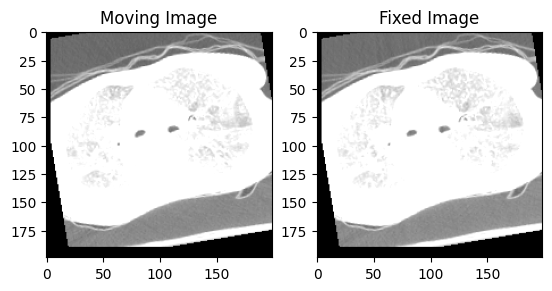

In [59]:
for i in range(len(generator)):
    moving_image, fixed_image = generator[i]
    print('moving image shape:', moving_image.shape, ' fixed image shape:', fixed_image.shape)
    print('data range of moving image:', np.min(moving_image), np.max(moving_image))

    # i want to plot side by side
    if i == 0:
        # set view window 
        WL = 40
        WW = 400
        fig, axs = plt.subplots(1, 2)
        moving_image_show = ff.set_window(np.flip(moving_image[:, :, moving_image.shape[2]//2-10].T,0), WL, WW)
        axs[0].imshow(moving_image_show, cmap='gray')
        axs[0].set_title('Moving Image')
        fixed_image_show = ff.set_window(np.flip(fixed_image[:, :, fixed_image.shape[2]//2-10].T,0), WL, WW)
        axs[1].imshow(fixed_image_show, cmap='gray')
        axs[1].set_title('Fixed Image')
        plt.show()
        break
   

In [49]:
print('data range of fixed_image_show: ', np.min(fixed_image_show), np.max(fixed_image_show))

data range of fixed_image_show:  0.1926678959935171 1.0


In [ ]:
image = nb.load()

# cuda实现

# put image into cuda

# 要写一个Spatial transorm module]
# 我要实现的是,image向左平移10个pixel



# 我要实现的是,image旋转绕着z轴 90


